In [1]:
import pandas as pd
import re
import itertools
from yaml import safe_dump
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
# Configuration
ZONE = 'NZ'
INPUT_FILE = 'edns-report-2018-06-12.txt'

In [3]:
some_errors = ['agrofresh.net.nz. nmho08u.rohmhaas.com: no address records found (NXDOMAIN)',
               'aheadstart.co.nz. ns3.ediy.co.nz: no address records found',
               'ahousethatperforms.co.nz. ns1.netdns.net: AAAA lookup failed',
               'airfarewatchdog.co.nz. ns1.smartertravelmedia.com: nameserver is a CNAME',
               'ceragem.co.nz. barcode.ceragem.co.kr: A nxdomain'
              ]

In [4]:
lookup_re = re.compile('((address|AAAA|A) lookup[s]? failed|no address records found|nameserver is a CNAME|A nxdomain)')

In [5]:
[lookup_re.search(l) for l in some_errors]

[<_sre.SRE_Match object; span=(40, 64), match='no address records found'>,
 <_sre.SRE_Match object; span=(34, 58), match='no address records found'>,
 <_sre.SRE_Match object; span=(42, 60), match='AAAA lookup failed'>,
 <_sre.SRE_Match object; span=(51, 72), match='nameserver is a CNAME'>,
 <_sre.SRE_Match object; span=(38, 48), match='A nxdomain'>]

In [6]:
lookup_errors = []
data = []
# The input file has a mix of lookup errors and the test results properly formatted
with open(INPUT_FILE, 'r') as f:
    for l in f.readlines():
        if lookup_re.search(l):
            lookup_errors.append(l.strip("\n"))
        else:
            p = l.strip("\n").split(' ')
            try:
                entry = {'domain': p[0], 'address': p[1], 'server': p[2]}
                for i in range(3, len(p)):
                    l, e = p[i].split('=')
                    entry[l] = e
                data.append(entry)
            except ValueError:
                print("Line with bad format? %s" % l)
            except IndexError:
                # print("Not enough fields in %s" % l)
                lookup_errors.append(l.strip("\n"))


In [7]:
d = pd.DataFrame(data)

In [8]:
d.head(5)

,address,dns,do,domain,edns,edns1,edns1opt,edns@512,ednsflags,ednsopt,ednstcp,optlist,server,signed
0,@210.55.30.66,ok,ok,0.co.nz.,ok,ok,ok,ok,ok,ok,ok,ok,(ns1.1stdomains.net.nz.):,ok
1,@210.55.30.66,ok,ok,0.net.nz.,ok,ok,ok,ok,ok,ok,ok,ok,(ns1.1stdomains.net.nz.):,ok
2,@175.41.131.225,ok,ok,0.co.nz.,ok,"noerror,badversion,soa","noerror,badversion,soa",ok,ok,ok,ok,"ok,nsid",(ns2.1stdomains.net.nz.):,ok
3,@175.41.131.225,ok,ok,0.net.nz.,ok,"noerror,badversion,soa","noerror,badversion,soa",ok,ok,ok,ok,"ok,nsid",(ns2.1stdomains.net.nz.):,ok
4,@210.55.30.66,ok,ok,001.co.nz.,ok,ok,ok,ok,ok,ok,ok,ok,(ns1.1stdomains.net.nz.):,ok


In [9]:
def explode_test(r, **kwargs):
    # This is a dataframe row, it should have address, domain, server and one extra field to split
    f = [a for a in r.keys() if a not in ['address', 'domain', 'server']][0]
    return [dict(list(r.items()) + [(f, v)]) for v in r[f].split(',')]

In [10]:
def summary_df(data=None, field=None):
    return pd.DataFrame([a for a in itertools.chain.from_iterable(data[['address', 'server', 'domain', field]].apply(explode_test, axis=1))])

In [11]:
n_dom = d['domain'].nunique()
n_addr = d['address'].nunique()
n_server = d['server'].nunique()

### Section 1: General DNS statistics

In [12]:
# Summary of errors for basic DNS test
s_dns = summary_df(data=d, field='dns')

In [13]:
s1 = s_dns.groupby(['dns']).count().reset_index()
s1['perc'] = 100* (s1['domain'] / s1['domain'].sum())
s1['error_type'] = s1.apply(lambda r: 'Other' if r['perc'] < 0.1 else r['dns'], axis=1)
s1b = s1[['error_type', 'perc', 'domain']].groupby(['error_type']).sum().reset_index().sort_values(by='perc', ascending=False)
s1b['test'] = 'dns'
s1b

,error_type,perc,domain,test
3,ok,88.554536,2113269,dns
6,timeout,4.382577,104586,dns
4,refused,4.283307,102217,dns
2,nosoa,1.046512,24974,dns
1,noaa,0.985164,23510,dns
5,servfail,0.584645,13952,dns
0,Other,0.163258,3896,dns


In [14]:
s1.head(2)

,dns,address,domain,server,perc,error_type
0,cd,1,1,1,0.000042,Other
1,connection-refused,120,120,120,0.005028,Other


In [15]:
s_dns.head(5)

,address,dns,domain,server
0,@210.55.30.66,ok,0.co.nz.,(ns1.1stdomains.net.nz.):
1,@210.55.30.66,ok,0.net.nz.,(ns1.1stdomains.net.nz.):
2,@175.41.131.225,ok,0.co.nz.,(ns2.1stdomains.net.nz.):
3,@175.41.131.225,ok,0.net.nz.,(ns2.1stdomains.net.nz.):
4,@210.55.30.66,ok,001.co.nz.,(ns1.1stdomains.net.nz.):


In [16]:
t_server_dns = s_dns[['dns', 'server', 'domain']].groupby(['server', 'dns']).count().reset_index()
# .pivot_table(index='server', columns='dns', values='domain', fill_value=0)

In [17]:
t_server_dns['frac'] = t_server_dns['domain'] / t_server_dns.groupby('server')['domain'].transform('sum')

In [18]:
t_server_dns.head(2)

,server,dns,domain,frac
0,(0001-ns-prod-ndc.ecnrtl.com.):,ok,1,1.0
1,(0002-ns-prod-ndc.ecnrtl.com.):,ok,1,1.0


In [19]:
frac_sum = t_server_dns['frac'].sum()

In [20]:
s_server_dns = (100 * (t_server_dns[['dns', 'frac']].groupby(['dns']).sum() / frac_sum)).reset_index().sort_values(by='frac', ascending=False)

[Text(0,0.5,''),
 (0, 100),
 Text(0.5,0,'Percentage'),
 Text(0.5,1,'Server result by DNS test -- NZ')]

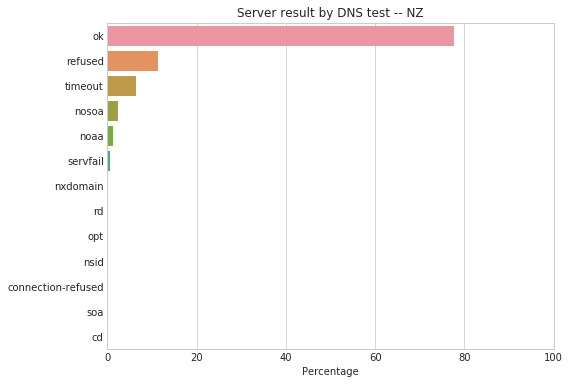

In [21]:
# Plot fraction of servers affected by each error at the DNS level
plt.figure(figsize=(8,6))
ax = sns.barplot(data=s_server_dns, x='frac', y='dns')
ax.set(xlim=[0, 100], title='Server result by DNS test -- %s' % ZONE, ylabel='', xlabel='Percentage')
# plt.savefig('nz-basic-DNS-test.png')

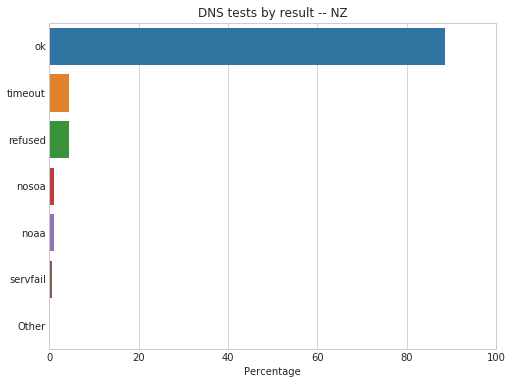

In [22]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data=s1b, x='perc', y='error_type')
ax.set(xlim=[0, 100], title='DNS tests by result -- %s' % ZONE, ylabel='', xlabel='Percentage')
plt.savefig('%s-basic-DNS-test.png' % ZONE)

### To analyze the tests properly, we need to describe them based on their dependencies. For example, if the dns test fails, the edns test is expected to fail.

![title](EDNS test decision tree.png)

In [23]:
def multiple_field_summary(data=None, fields=[]):
    slist = []
    for c in fields:
        if c in ['address', 'server', 'domain', 'dns']:
            continue
        # temporary dataframe with the specific output
        tmp_s = summary_df(data=data, field=c)
        print("Column = %s" % c)
        sg = tmp_s.groupby([c]).count().reset_index()
        sg['perc'] = 100* (sg['domain'] / sg['domain'].sum())
        sg['error_type'] = sg.apply(lambda r: 'Other' if r['perc'] < 0.1 else r[c], axis=1)
        sg2 = sg[['error_type', 'perc', 'domain']].groupby(['error_type']).sum().reset_index().sort_values(by='perc', ascending=False)
        sg2['test'] = c
        slist.append(sg2)
    
    return pd.concat(slist)

In [24]:
def plot_comparison(data=None, title=None, figfile=None, zone=None):
    sns.set(style='whitegrid', font_scale=1.6)
    plt.figure(figsize=(16,9))
    ax = sns.barplot(data=data, x='perc', y='error_type', hue='test', ci=None)
    ax.set(xlim=[0, 100], title=title % zone, ylabel='', xlabel='Percentage')
    plt.savefig(figfile % zone)

### Error summary by test and by server where dns=ok and where the test is 'edns' or 'edns1' 

In [25]:
s_edns_edns1 = multiple_field_summary(data=d[d['dns']=='ok'], fields=['edns', 'edns1'])

Column = edns
Column = edns1


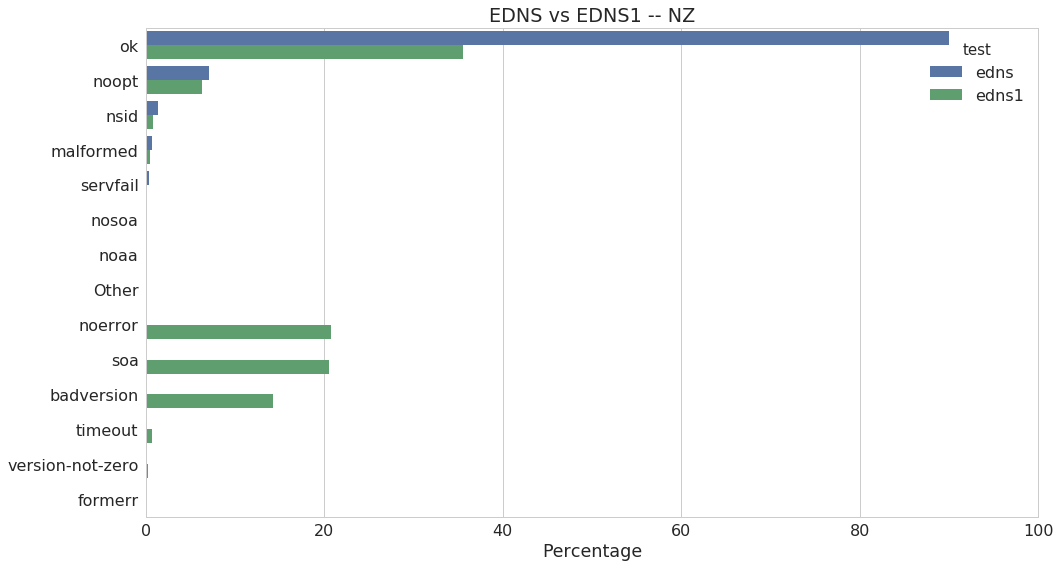

In [26]:
plot_comparison(data=s_edns_edns1, title='EDNS vs EDNS1 -- %s', figfile='%s-EDNS-EDNS1.png', zone=ZONE)

### Compare results of 'edns1' and 'edns1opt' tests when dns=ok and edns1=ok

In [27]:
s_edns1opt = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns1']=='ok')], fields=['edns1', 'edns1opt'])

Column = edns1
Column = edns1opt


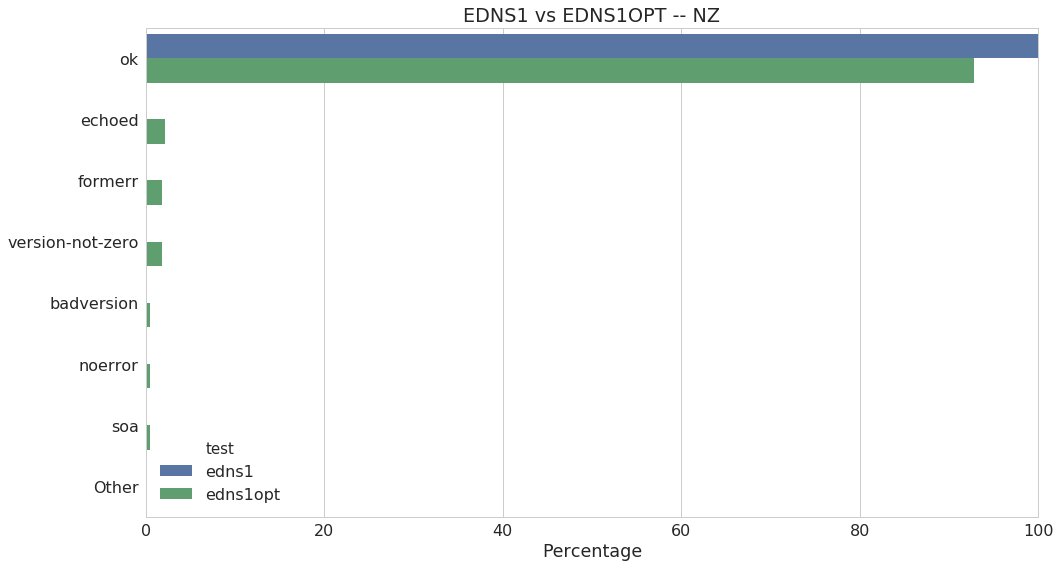

In [28]:
plot_comparison(data=s_edns1opt, title='EDNS1 vs EDNS1OPT -- %s', figfile='%s-EDNS1-EDNS1OPT.png', zone=ZONE)

### Compare results of 'do' and 'edns' 

In [29]:
s_do_edns = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok')], fields=['edns', 'do'])

Column = edns
Column = do


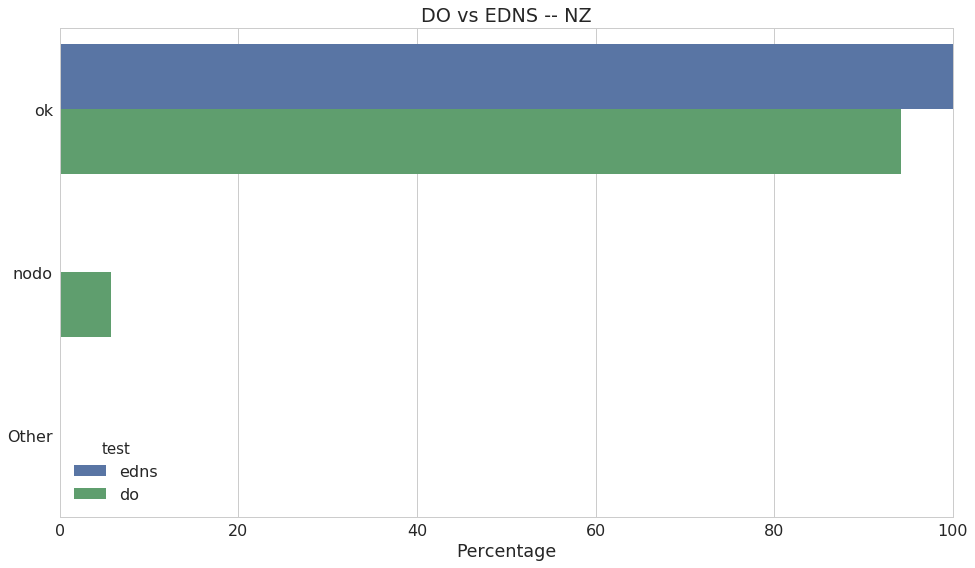

In [30]:
plot_comparison(data=s_do_edns, title='DO vs EDNS -- %s', figfile='%s-DO-EDNS.png', zone=ZONE)

### Compare results of 'do', 'ednstcp', 'edns@512' when edns=ok and do=ok

In [31]:
s_ednstcp = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok') & (d['do']=='ok')],
                                   fields=['do', 'ednstcp', 'edns@512'])

Column = do
Column = ednstcp
Column = edns@512


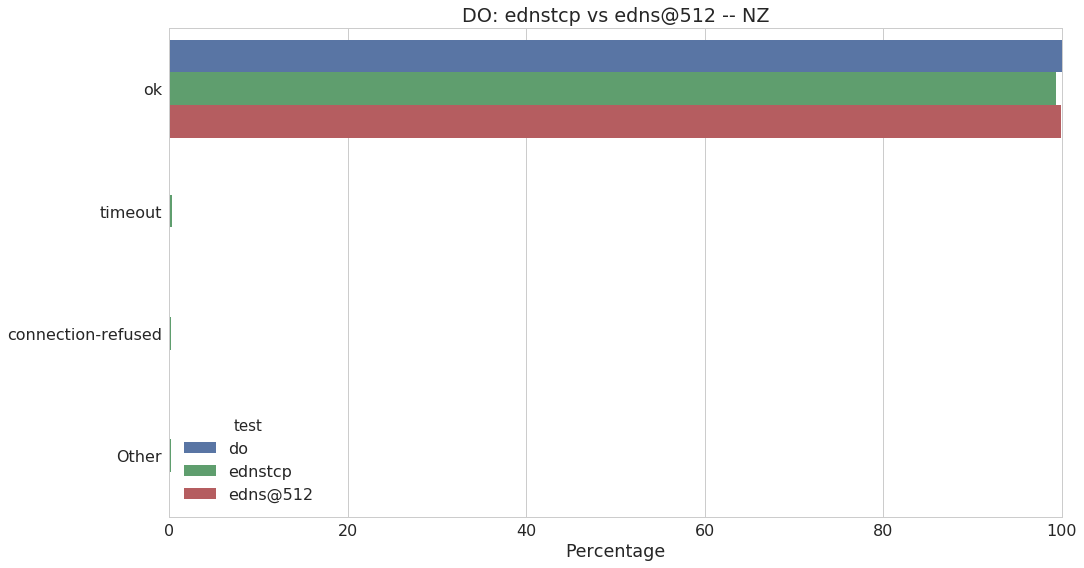

In [32]:
plot_comparison(data=s_ednstcp, title='DO: ednstcp vs edns@512 -- %s', figfile='%s-do-ednstcp-edns512.png', zone=ZONE)

### Compare 'edns' with 'ednsflags' when edns=ok

In [33]:
s_ednsflags = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok')],
                                   fields=['edns', 'ednsflags'])

Column = edns
Column = ednsflags


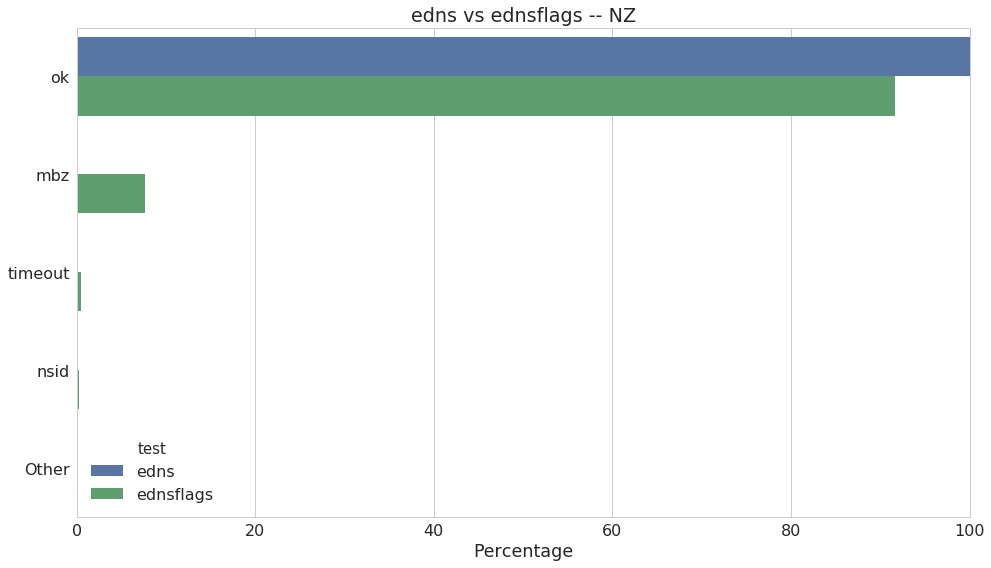

In [34]:
plot_comparison(data=s_ednsflags, title='edns vs ednsflags -- %s', figfile='%s-edns-ednsflags.png', zone=ZONE)
# plt.figure(figsize=(16,9))
# sns.barplot(data=s_ednsflags, x='perc', y='error_type', hue='test', ci=None)
# plt.savefig('nz-all-other-tests.png')

### Compare edns with optlist when edns=ok

In [35]:
s_optlist = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok')],
                                   fields=['edns', 'optlist'])

Column = edns
Column = optlist


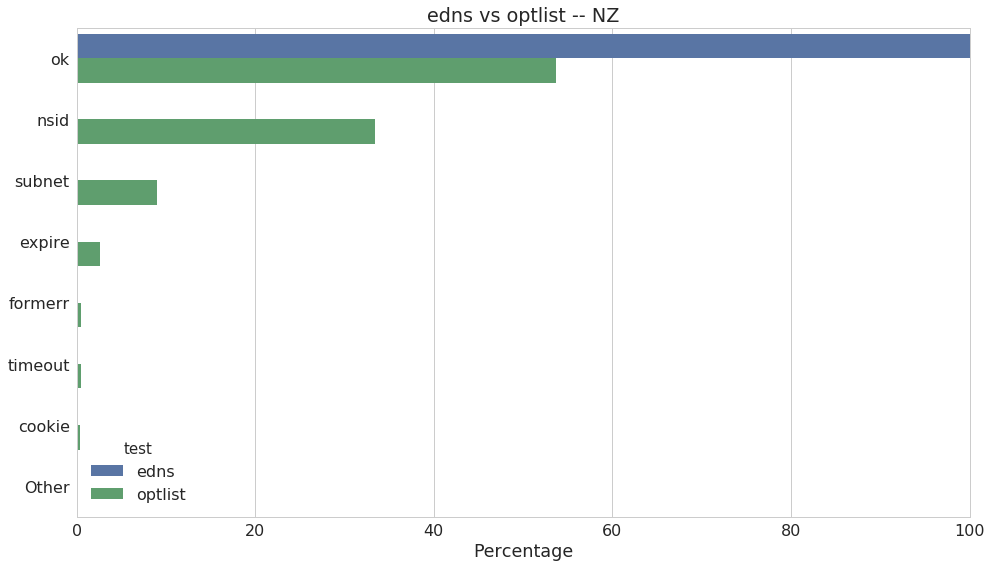

In [36]:
plot_comparison(data=s_optlist, title='edns vs optlist -- %s', figfile='%s-edns-optlist.png', zone=ZONE)

### Calculate a correctness score per server/address pair

In [37]:
d.columns

Index(['address', 'dns', 'do', 'domain', 'edns', 'edns1', 'edns1opt',
       'edns@512', 'ednsflags', 'ednsopt', 'ednstcp', 'optlist', 'server',
       'signed'],
      dtype='object')

In [70]:
import ipaddress

In [76]:
d['family'] = d['address'].apply(lambda x: ipaddress.ip_address(x[1:]).version)

In [77]:
sel_fields = [c for c in d.columns if c not in ['signed']]
d2 = d[sel_fields].melt(id_vars=['server', 'address', 'domain', 'family'])

In [78]:
d2.head(5)

,server,address,domain,family,variable,value
0,(ns1.1stdomains.net.nz.):,@210.55.30.66,0.co.nz.,4,dns,ok
1,(ns1.1stdomains.net.nz.):,@210.55.30.66,0.net.nz.,4,dns,ok
2,(ns2.1stdomains.net.nz.):,@175.41.131.225,0.co.nz.,4,dns,ok
3,(ns2.1stdomains.net.nz.):,@175.41.131.225,0.net.nz.,4,dns,ok
4,(ns1.1stdomains.net.nz.):,@210.55.30.66,001.co.nz.,4,dns,ok


In [79]:
d2[d2['value'].str.contains('ok')]['value'].unique()

array(['ok', 'ok,nsid', 'ok,nsid,subnet', 'ok,expire', 'ok,subnet',
       'refused,cookie,subnet', 'ok,nsid,expire',
       'ok,cookie+badcookie,subnet', 'ok,cookie,subnet',
       'ok,expire,cookie,subnet', 'nosoa,noaa,nsid,cookie',
       'refused,cookie', 'ok,nsid,expire,subnet',
       'ok,nsid,expire,cookie,subnet', 'ok,expire,cookie',
       'refused,nsid,cookie,subnet', 'ok,cookie', 'ok,nsid,expire,cookie',
       'ok,expire,subnet', 'nosoa,noaa,cookie,subnet',
       'ok,nsid,cookie+badcookie,subnet', 'nosoa,noaa,nsid,cookie,subnet',
       'nosoa,cookie,subnet', 'servfail,cookie,subnet', 'nosoa,cookie',
       'servfail,nsid,cookie,subnet'], dtype=object)

In [80]:
d2['score'] = d2['value'].apply(lambda x: 1.0 if x=='ok' else 0.8 if 'ok' in x else 0.0)

In [81]:
server_addr_score = d2.groupby(['server', 'address'])['score'].apply(lambda x: x.sum()/len(x)).reset_index()

In [83]:
server_addr_score['score'].describe()

count    42472.000000
mean         0.735028
std          0.320901
min          0.000000
25%          0.580000
50%          0.885714
75%          1.000000
max          1.000000
Name: score, dtype: float64

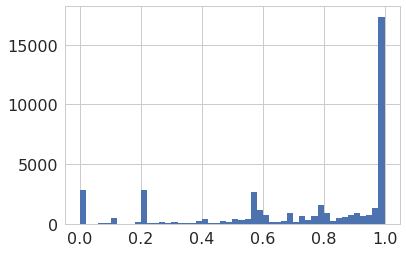

In [84]:
server_addr_score['score'].hist(bins=50)

In [85]:
domain_score = d2.groupby(['domain'])['score'].apply(lambda x: x.sum()/len(x)).reset_index()

In [87]:
domain_score['score'].describe()

count    690807.000000
mean          0.768583
std           0.271111
min           0.000000
25%           0.585000
50%           0.890000
75%           0.980000
max           1.000000
Name: score, dtype: float64

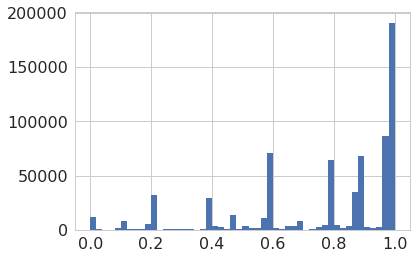

In [88]:
domain_score['score'].hist(bins=50)

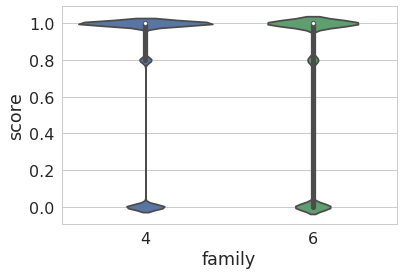

In [91]:
# Check if IPv4 address get better scores than IPv6 addresses
sns.violinplot(data=d2[['family', 'score']], x='family', y='score')